## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


MemoryError: 

## Import data and clean the text

In [2]:
loader = DataLoader()
d =loader.GetData('final')
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
0,1003246377,21120199,古丽依娜·买买提克力木,2021-22冬季通用英语C2刘学青1005期末,法学院,1002658406(刘学青),C,19121438,9.0,...
1,1003248323,21122145,王名振,2021-22冬季通用英语B2谢怡沁1014期末,通信与信息工程学院,1002658415(谢怡沁),B,19121435,9.6,"As a person, the people around us are always c..."
2,1003249593,21123420,周祺,2021-22冬季通用英语C2刘学青1016期末,上海美术学院,1002658406(刘学青),C,19121440,8.7,"Since we are little, we have been told to read..."
3,1003250643,21124470,张芷昕,2021-22冬季通用学术英语A2张新玲1008期末,音乐学院,1002658431(张新玲),A,1000561535,11.1,"With the development of networks, Internet i..."
4,1003246209,21120031,晏三,2021-22冬季通用英语B2谢怡沁1014期末,法学院,1002658415(谢怡沁),B,19121437,10.5,"As we all know, friendship is essential for th..."


In [3]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    cleaned = preproc(essay.replace("'s", "'s '").replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

### Load similarity matrices

In [4]:
f = np.load('features/final_winter_sent.npz')

In [5]:
sim_list = [f[a] for a in f.files]

## Get mean, max and min values of sim matrices

In [6]:
sim_raw_list = []
for n in f.files:
    values = []
    m = f[n]
    for row in range(len(m)):
        for col in range(row+1,len(m)):
            values.append(m[row,col])
    sim_raw_list.append(np.array(values))

In [11]:
sim_mean = []
sim_max = []
sim_min = []
sim_var = []
sim_corr_mean = []
for matrix in sim_raw_list:
    if len(matrix) > 1:
        sim_mean.append(np.average(matrix))
        sim_max.append(np.max(matrix))
        sim_min.append(np.min(matrix))
        sim_var.append(np.var(matrix))
        avg = []
        for i in range(len(matrix) // 10):
            avg.append(np.average(matrix[i*10:i*10+10]))
        sim_corr_mean.append(np.average(avg))
    else:
        sim_mean.append(0)
        sim_max.append(0)
        sim_min.append(0)
        sim_corr_mean.append(0)
        sim_var.append(0)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Get cluster data

In [12]:
cluster_num = []
bigram_sim = []
cluster_avg = []
row1_sim = []
for k in range(len(sim_list)):
    sim = sim_list[k]
    if len(sim) > 1:
        sim_thres = sim.copy()
        for i in range(len(sim_thres)):
            for j in range(len(sim_thres)):
                if sim_thres[i,j] <= np.percentile(np.array(sim_raw_list[k]),50):
                    sim_thres[i,j] = 0
        res = mcl.run_mcl(sim_thres,inflation=2)
        clusters = mcl.get_clusters(res)
        cluster_num.append(len(clusters))
        cluster_avg.append(len(sim)/len(clusters))
        bigram = []
        for i in range(len(sim)-1):
            bigram.append(sim[i,i+1])
        bigram_sim.append(np.average(np.array(bigram)))
        row1_sim.append(np.average(sim[0,1:]))
    else:
        cluster_num.append(0)
        bigram_sim.append(0)
        row1_sim.append(0)
        cluster_avg.append(0)

### Add data to dataframe

In [13]:
d = loader.GetData('final')
d['mean'] = sim_mean
d['max'] = sim_max
d['min'] = sim_min
d['cluster_num'] = cluster_num
d['bigram_sim'] = bigram_sim
d['row1_sim'] = row1_sim
d['cluster_avg'] = cluster_avg        
d['corr_mean'] = sim_corr_mean  
d['variance'] = sim_var                                            

### Select non-zero scores, and add level percentile

In [14]:
d = shuffle(d,random_state=1000)
d = d.loc[d['score'] > 0]
d.loc[:,'level'] = 0
percentiles = []
for i in range(10,100,10):
    percentiles.append(np.percentile(d['score'],i))
d.loc[d['score'] <= percentiles[0],'level'] = '100'
for i in range(8):
    d.loc[(d['score'] <= percentiles[i+1]) & (d['score'] > percentiles[i]),'level'] = str((10-i-1)*10)
d.loc[d['score'] > percentiles[-1],'level'] = '10'

In [15]:
ind = list(d.index)
trainIn,testIn = ind[:2838],ind[2838:]

## Linear regression

In [16]:
model = pg.linear_regression(d.loc[trainIn,['mean','min','max','cluster_num','cluster_avg']],d.loc[trainIn,'score'],relimp=True,remove_na=True)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,7.469416,0.189974,39.318066,3.402384e-270,0.218,0.216619,7.096914,7.841917,NaN,NaN
1,mean,-3.270073,1.205032,-2.713682,6.694306e-03,0.218,0.216619,-5.632901,-0.907244,0.023803,10.919004
2,min,-8.790777,1.495267,-5.879067,4.608382e-09,0.218,0.216619,-11.722700,-5.858853,0.033417,15.328970
3,max,-0.554362,0.243131,-2.280096,2.267603e-02,0.218,0.216619,-1.031094,-0.077630,0.003909,1.792907
4,cluster_num,0.434016,0.019843,21.872341,4.058990e-98,0.218,0.216619,0.395107,0.472924,0.119242,54.698399
5,cluster_avg,0.520954,0.032899,15.834870,3.529975e-54,0.218,0.216619,0.456445,0.585462,0.037628,17.260720


In [98]:
for i in range(1,6):
    print('{:.2f}%'.format(model['relimp'][i]*100))

2.38%
3.34%
0.39%
11.92%
3.76%


In [17]:
TrainX,TestX = [list(d.loc[i,['mean','min','max','cluster_num','cluster_avg']]) for i in trainIn],[list(d.loc[i,['mean','min','max','cluster_num','cluster_avg']]) for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [18]:
model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

In [19]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(1.247442196398633, 0.2000015043552017, 0.19723716749536901)

In [20]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(1.189207278235187, 0.21799953182798382, 0.2179995318279837)

## Logistic regression

In [33]:
model = sm.MNLogit(d.loc[trainIn,'Class'],d.loc[trainIn,['mean','min','max','cluster_num','cluster_avg']])
model_res = model.fit()
model_res.summary()

Optimization terminated successfully.
         Current function value: 1.180993
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                  Class   No. Observations:                 2838
Model:                        MNLogit   Df Residuals:                     2823
Method:                           MLE   Df Model:                           12
Date:                Sat, 06 May 2023   Pseudo R-squ.:                 0.02421
Time:                        14:56:39   Log-Likelihood:                -3351.7
converged:                       True   LL-Null:                       -3434.8
Covariance Type:            nonrobust   LLR p-value:                 2.697e-29
===============================================================================
    Class=B       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean            8.2024      2.680      3.061      0.002       2.950      13.455
min            -3.2245      3.747     -0.860      0.390     -10.569       4.120
max             0.2283      0.588      0.388      0.698      -0.923       1.380
cluster_num    -0.0042      0.020     -0.209      0.834      -0.044       0.035
cluster_avg    -0.0897      0.071     -1.257      0.209      -0.229       0.050
-------------------------------------------------------------------------------
    Class=C       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean           12.0749      2.856      4.228      0.000       6.477      17.672
min             1.6433      3.913      0.420      0.674      -6.025       9.312
max             0.8177      0.622      1.314      0.189      -0.402       2.037
cluster_num    -0.1700      0.023     -7.333      0.000      -0.215      -0.125
cluster_avg    -0.2824      0.076     -3.694      0.000      -0.432      -0.133
-------------------------------------------------------------------------------
    Class=D       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean           11.4442      4.373      2.617      0.009       2.874      20.014
min            -3.1552      5.821     -0.542      0.588     -14.565       8.255
max             0.8913      0.948      0.940      0.347      -0.966       2.749
cluster_num    -0.3649      0.040     -9.146      0.000      -0.443      -0.287
cluster_avg    -0.4368      0.120     -3.641      0.000      -0.672      -0.202
===============================================================================
"""

In [74]:
for i in range(5):
    print('[{:.2f}, {:.2f}]'.format(model_res.conf_int().loc['D','lower'][i],model_res.conf_int().loc['D','upper'][i]))

[2.87, 20.01]
[-14.57, 8.25]
[-0.97, 2.75]
[-0.44, -0.29]
[-0.67, -0.20]


In [34]:
TrainX,TestX = d.loc[trainIn,['mean','min','max','cluster_num','cluster_avg']],d.loc[testIn,['mean','min','max','cluster_num','cluster_avg']]
TrainY,TestY = d['Class'][trainIn],d['Class'][testIn]

In [43]:
res = {0:'A',1:'B',2:'C',3:'D'}
PredY = [res[model_res.predict(TestX).loc[j].argmax()] for j in testIn]
PredTrainY = [res[model_res.predict(TrainX).loc[j].argmax()] for j in trainIn]

In [51]:
accuracy_score(TestY,PredY),f1_score(TestY,PredY,average='weighted')

(0.4619450317124736, 0.3409964805604054)

In [49]:
accuracy_score(TrainY,PredTrainY),f1_score(TrainY,PredTrainY,average='weighted')

(0.45771670190274844, 0.3383239778375922)

### Plot some results

Text(0.5, 12.44444444444443, 'top n% in scores')

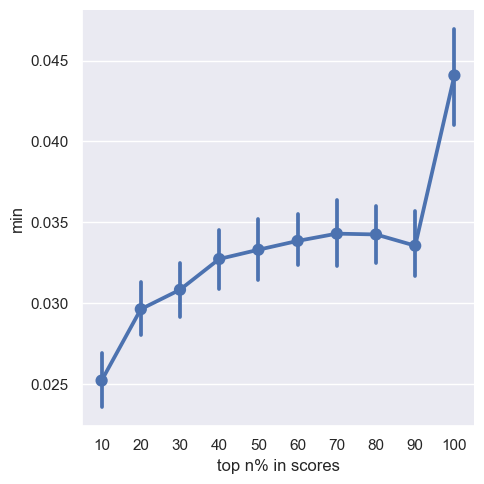

In [28]:
sns.set_theme(style='darkgrid')
sns.catplot(d,y='min',x='level',kind='point',order=[str(i*10) for i in range(1,11)])
#order=[str(i*10) for i in range(1,11)] ['A','B','C','D']
plt.xlabel('top n% in scores')

## Some examples: 2888,2087,1067

In [52]:
sim = f[f.files[1067]]

In [54]:
sim_thres = sim.copy()
for i in range(len(sim_thres)):
    for j in range(len(sim_thres)):
        if sim_thres[i,j] <= np.percentile(sim_raw_list[1067],50):
            sim_thres[i,j] = 0

In [55]:
np.average(sim_raw_list[1067])

0.1280130338401495

In [56]:
np.percentile(sim_raw_list[1067],90)

0.21336758485221394

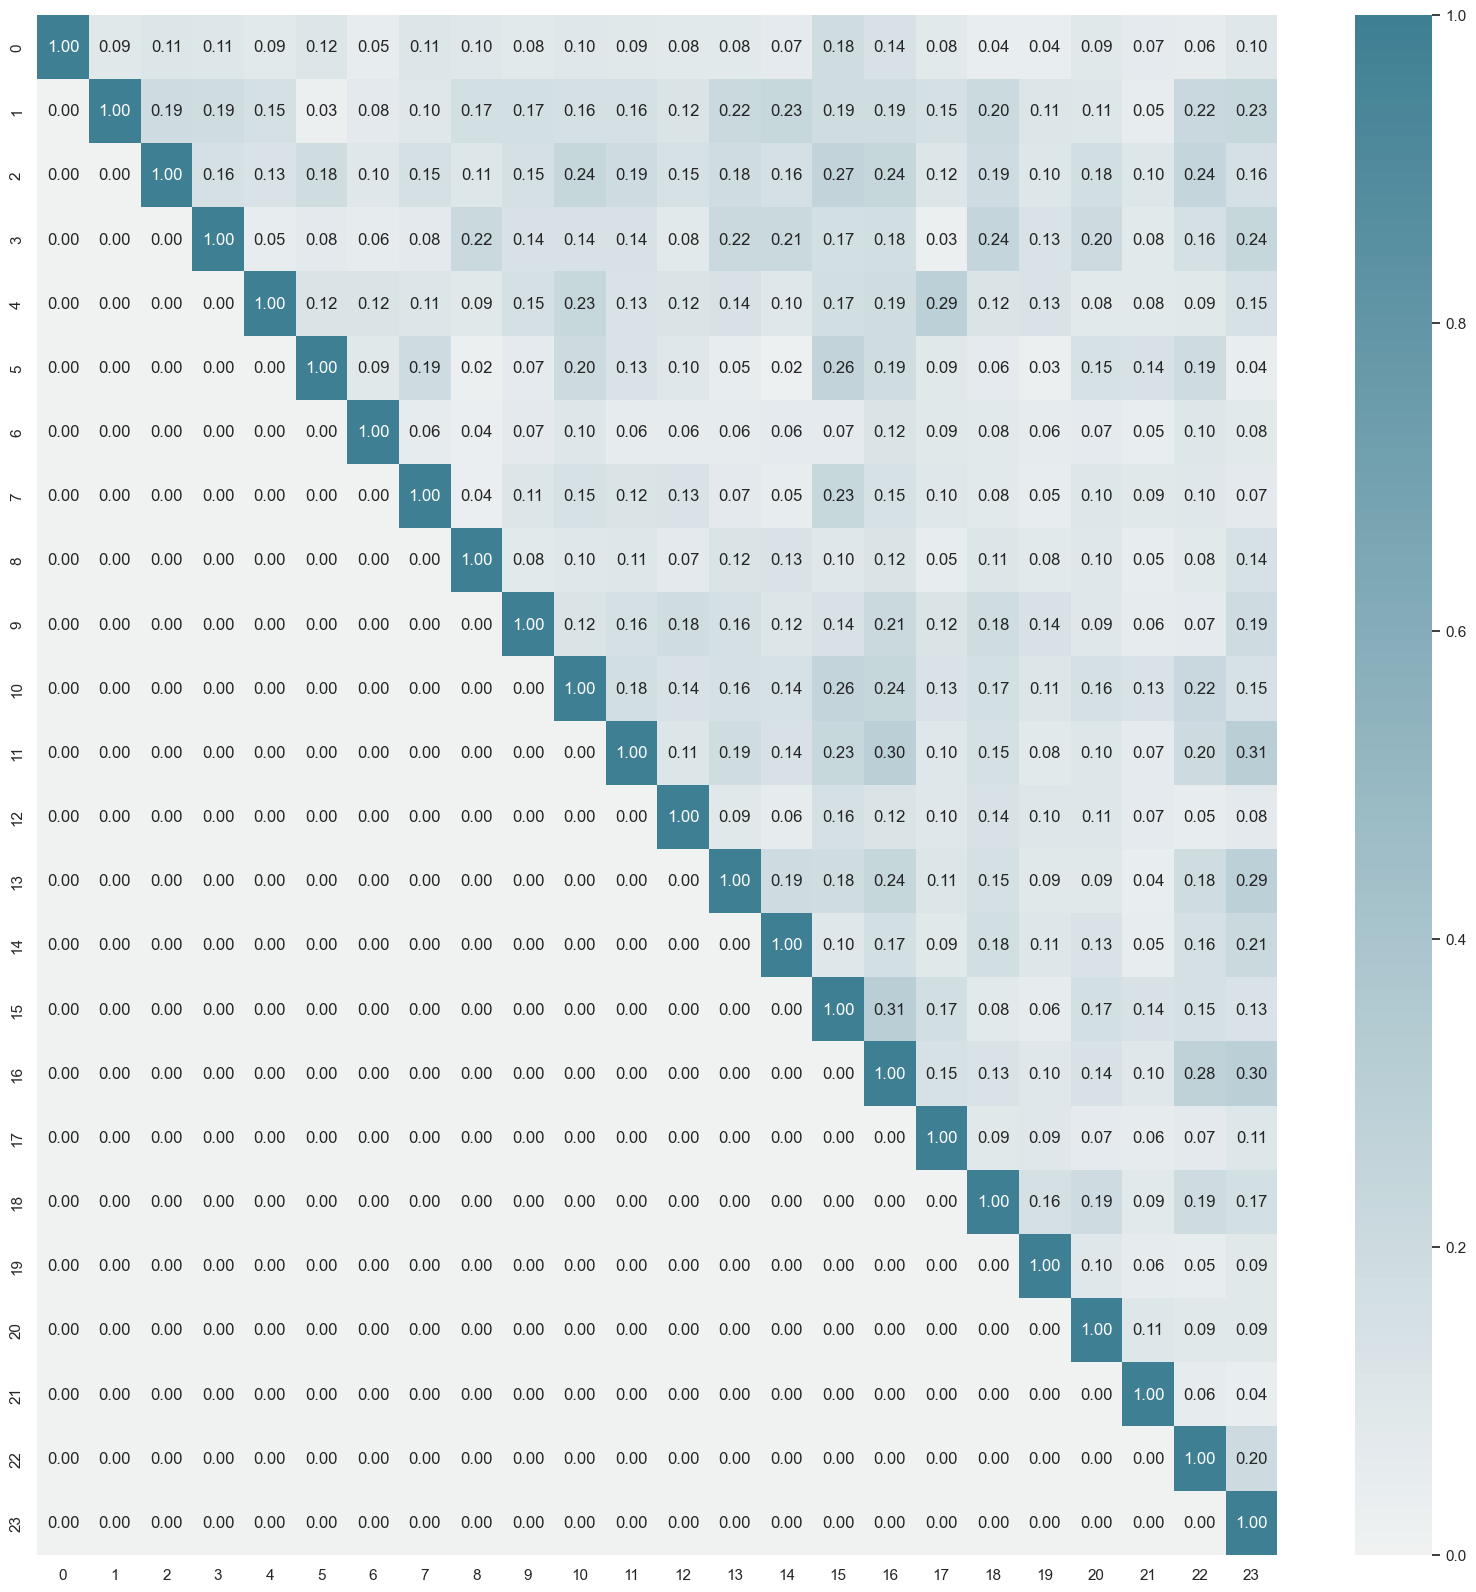

In [57]:
c = sns.diverging_palette(20, 220, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))   
g = sns.heatmap(sim,vmin=0,vmax=1,center=0,annot=True,fmt='.2f',cmap=c)

In [58]:
np.fill_diagonal(sim_thres,0)
res = mcl.run_mcl(sim_thres,inflation=2)
clusters = mcl.get_clusters(res)

In [59]:
len(clusters)

9

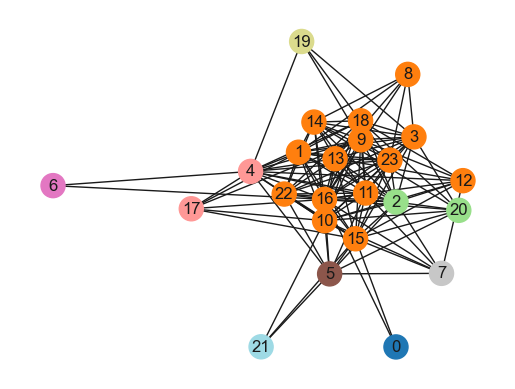

In [60]:
mcl.draw_graph(sim_thres,clusters)

In [97]:
doc = NLP(d['text'][1067])

In [99]:
for i in range(len(sents)):
    print(i,sents[i])

0 It's ' known to all that we need to read a bulk of books if we want to keep abreast of time.
1 However, many people fail to read fast, which lowers their reading efficiency.
2 As a person who enjoy reading a lot, I conclude several tips on how to improve your reading spead.
3 The tips are as follows.
4 First, don't read articles aloud or in mind.
5 There are a number of people read books with a voice in their mind without noticing.
6 It amounts that reading books aloud is a slow way of reading books, regardless of reading aloud or just in mind.
7 So we have to avoid reading books with a voice in our mind and try to understand the words in the books just with our eyes.
8 It can be done if you train yourself several times.
9 Second, use a ruler or a pencil to show which line you are reading now.
10 You can move your ruler slowly to the next line at first.
11 This can help you to keep focus on the article and know your reading speed.
12 Then try to move the ruler a little bit quicker to

In [98]:
sents = [j for j in doc.sents if len(str(j).split()) > 3]

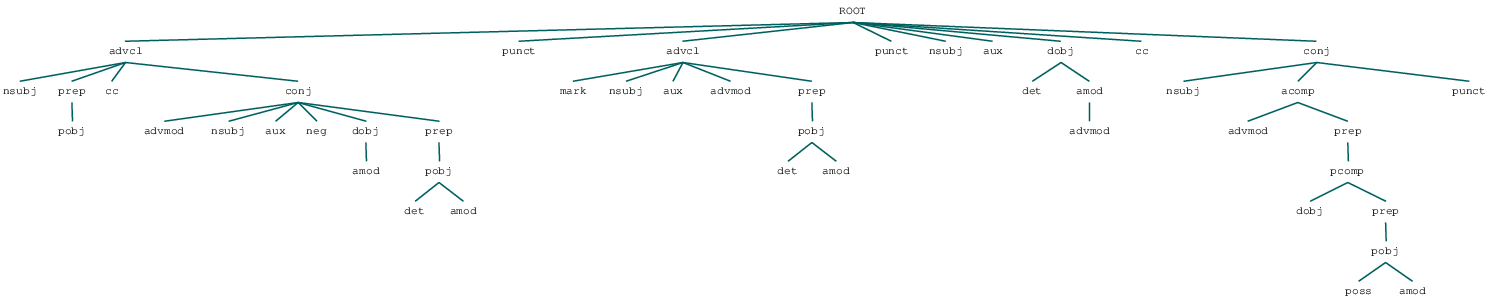

In [95]:
CreateDepTree(sents[11].root)

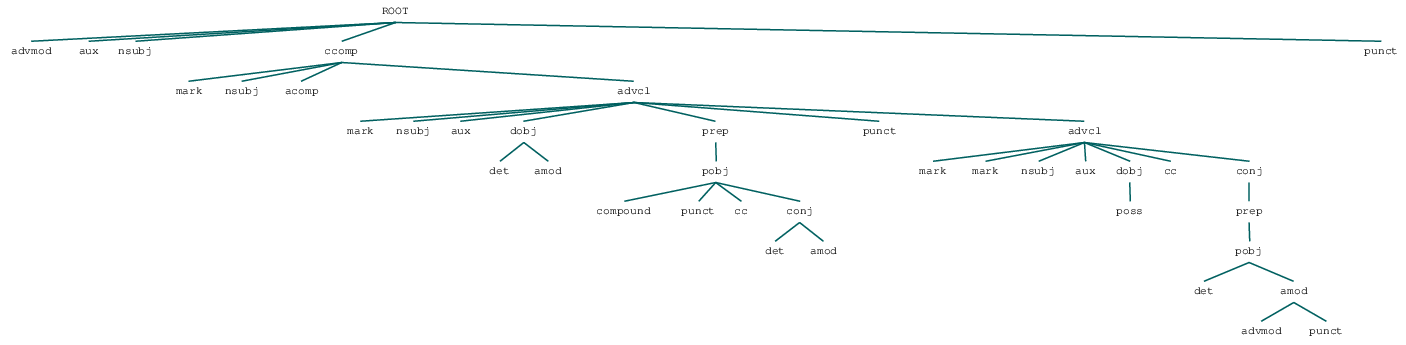

In [96]:
CreateDepTree(sents[25].root)

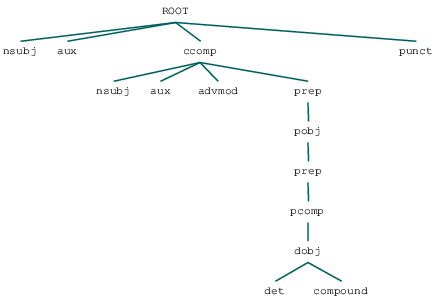

In [77]:
CreateDepTree(sents[16].root)

In [100]:
trps = []
self_sim = []
for i in range(len(sents)):
    self_sim.append(PartialTreeKernel(sents[i],sents[i]))
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        #sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])
        trps.append((sents[i],sents[j],PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])))
sorted(trps,key=lambda x:x[2],reverse=True)

[(This can help you to keep focus on the article and know your reading speed.,
  You will find you can read fast by virtue of having no speed markers.,
  0.34862053151765227),
 (After that, you can try to read without a speed marker.,
  You will find you can read fast by virtue of having no speed markers.,
  0.3117936344524934),
 (You will find you can read fast by virtue of having no speed markers.,
  I really hope that my advice can help you.,
  0.30424950813694485),
 (Finally, you will find your reading speed is quicker a lot.,
  I really hope that my advice can help you.,
  0.2939399279545463),
 (First, don't read articles aloud or in mind.,
  Last but not least, improving reading speed doesn't mean read fast at anytime.,
  0.2917615591640047),
 (This can help you to keep focus on the article and know your reading speed.,
  I really hope that my advice can help you.,
  0.2756602964946008),
 (You will find you can read fast by virtue of having no speed markers.,
  These are my tips 